# A/B Testing 

Cookie Cat 은 귀여운 고양이가 나오는 모바일 게임입니다.    
[게임링크](https://play.google.com/store/apps/details?id=dk.tactile.cookiecats&hl=en&gl=US)   

유저들은 초반에는 편하게 게임을 즐길 수 있습니다. 그러나 어느 순간이 되면 광고를 보거나 인앱 결제를 진행하라는 문구를 보게 됩니다.    
해당 문구를 언제 배치하는게 좋을까요?     
30번째 관문 (Gate 30)일까요 혹은 40번째 관문 (Gate 40) 일까요?   

### summary

1) 전처리 : 기본적인 데이터 확인 및 전처리   
2) 분포 확인 : 통계 분석을 하기 전 전체적인 데이터의 분포를 확인하였습니다. 이를 통해 데이터가 충분히 균형있는지 확인하였습니다.   
3) A/B 테스트 : 3개의 metric (총 게임 시행 횟수, 1일 뒤 다시 게임 실행 여부, 7일 뒤 게임 실행 여부) 에 대해 Gate 30, 40 이 미치는 영향에 대해서 A/B test 수행하였습니다.   
- 가설을 세우고 통계적으로 검증하였습니다 (순열 리샘플링을 통한 분포 확인, pvalue 도출, alpha=0.5)  

In [135]:
from IPython.display import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
path=os.getenv('HOME')+'/Base_DataScience/cookie_cats.csv'
df=pd.read_csv(path)
#각 고객의 데이터 입니다. 어떤 고객은 30번에, 어떤 고객은 40번에 결제 권유 팝업이 떠 있는 것을 볼 수 있습니다. 
#이 두 집단의 A/B test 결과를 확인하여 어떤 웹 구성이 더 비즈니스에 이로운지 판단하도록 하겠습니다.


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [127]:
#지표
    #Version : A,B 그룹 (Gate_30 : 30번 플레이 후 인앱 구매 요구, Gate40 : 40번 플레이 후 인앱 구매 요구)
    #Sum_gamerounds:설치 후 14일 동안 게임 이용 수
    #retention_1: 설치 1일 후 다시 게임을 이용했나?
    #retention_7: 설치 7일 후 다시 게임을 이용했나?

# 1. 전처리

In [8]:
#1) 누락 확인
df.isna().sum() #누락 없음

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

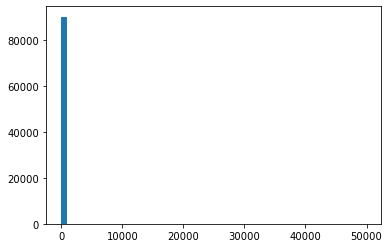

In [15]:
#2) 이상치 확인
plt.hist(df.sum_gamerounds, bins=50)
plt.show()

In [16]:
#총 게임 플레이수에서 49000이 넘는 수치가 나온다 : 이상치로 보인다. -> 추가 확인작업
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [19]:
#정렬해보니 최대값 1개만 49850 이고 나머지는 2900까지 어느정도 순차적으로 분포되어있다. => 해당 이상치는 제거하기로 한다. 
df.sort_values(by='sum_gamerounds', ascending=False).head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True
87007,9640085,gate_30,2156,True,True
36933,4090246,gate_40,2124,True,True
88328,9791599,gate_40,2063,True,True
6536,725080,gate_40,2015,True,True


In [23]:
df=df[df.index!=57702]

# 2. 분포 확인

### 1) Version (A/B) 분포

In [25]:

#데이터의 분포는 거의 균일하다 (각각, 49, 50% 를 차지하고 있다)
df.groupby('version').size()/len(df)

version
gate_30    0.49562
gate_40    0.50438
dtype: float64

### 2) Retention 분포

In [31]:
df.groupby('retention_1').size()/len(df)

retention_1
False    0.554786
True     0.445214
dtype: float64

In [30]:
df.groupby('retention_7').size()/len(df)

retention_7
False    0.813944
True     0.186056
dtype: float64

<AxesSubplot:xlabel='sum_gamerounds'>

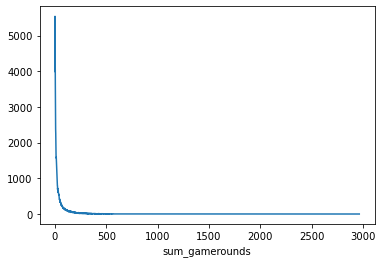

In [38]:
game=df.groupby("sum_gamerounds")['userid'].count()
game.plot()

# 3. A/B 테스트

## 1) Sum_gamerounds - 가설 : 30 그룹이 이 40 그룹보다 14일간 총 게임 플레이 횟수가 높을 것이다. 

- Ho: gate 30's(GroupA) sum_gamerounds = gate 40's(GroupA) sum_gamerounds 
- Ha: gate 30's(GroupA) sum_gamerounds > gate 40's(GroupA) sum_gamerounds 

alpha=0.05

*Gate_30 : 30번 게임 후 인앱 구매 알림 / Gate_40 : 40번 구매후 인앱 구매 알림
*Sum_gamerounds: 설치 후 14일간 게임 플레이 수

<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

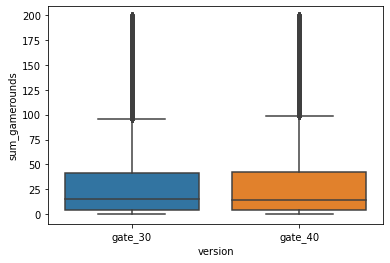

In [79]:
#우리가 가진 통계량 확인
sns.boxplot(x='version', y='sum_gamerounds', data=df[df['sum_gamerounds']<200])

### Permutation test 를 통해 도출한 차이가 통계적으로 유의미한지 확인할 것이다. 

In [85]:
gate_30=df[df['version']=='gate_30']
gate_40=df[df['version']=='gate_40']
mean_sampel_difference=gate_30['sum_gamerounds'].mean()-gate_40['sum_gamerounds'].mean()
mean_sampel_difference
# 전체적으로 봤을때 Gate 30이 40 보다 0.04만큼 30이 더 높다. 해당의 오차는 유의미할까?

0.04333503360787461

In [68]:
a=sum(df['version']=='gate_30')
b=sum(df['version']=='gate_40')

In [72]:
mean_diff_list=[]
for i in range(1000):
    a_table=df.sample(n=a)
    b_table=df[~df.index.isin(a_table.index)]
    mean_diff=a_table['sum_gamerounds'].mean()-b_table['sum_gamerounds'].mean()
    mean_diff_list.append(mean_diff)

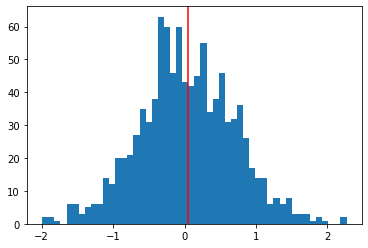

In [86]:
#헤당 그래프는 순열 리샘플링을 통해서 확인한 일반적인 두 샘플의 round 차이이다.
#빨간 선이 우리가 가진 표본값이다. (두 집단의 평균 sum game rounds 차리)
plt.hist(mean_diff_list, bins=50)
plt.axvline(x=mean_sampel_difference, color='r')
plt.show()


In [106]:
#Pvalue 는 빨간선 오른쪽 영역의 확률값 : 0.479로 매우 높음 => alpha 0.9 > p value
#가설 기각
# 30초 후에 보여주나 40초 후에 보여주나 유저의 게임 활동 횟수에 큰 차이가 없다.
sum(np.array(mean_diff_list)>mean_sampel_difference)/len(mean_diff_list)

0.479

## 2) Retention1 - 가설 : A 그룹이 B 그룹보다 Retention_1이 높을 것이다.

- Ho : A(gate_30) 의 retention_1 = B(gate_40) 의 retention_1
- Ha : A(gate_30) 의 retention_1 > B(gate_40) 의 retention_1
- alpha = 0.05   

*Gate_30 : 30번 게임 후 인앱 구매 알림 / Gate_40 : 40번 구매후 인앱 구매 알림   
*Retention_1: 다운로드 1일 후 게임 계속 플레이 하는가? 

In [121]:
def permutation_test(metrics):
    mean_diff_list=[]
    a=sum(df['version']=='gate_30')
    b=sum(df['version']=='gate_40')
    for i in range(1000):
        a_table=df.sample(n=a)
        b_table=df[~df.index.isin(a_table.index)]
        mean_diff=a_table[metrics].sum()/a-b_table[metrics].sum()/b
        mean_diff_list.append(mean_diff)
    mean_sample_difference=mean_sampel_difference=gate_30[metrics].sum()/a-gate_40[metrics].sum()/b

    plt.hist(mean_diff_list, bins=50)
    plt.axvline(x=mean_sampel_difference, color='r')
    plt.show()
    return sum(np.array(mean_diff_list)>mean_sampel_difference)/len(mean_diff_list)

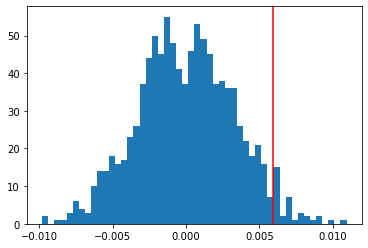

0.035

In [122]:
### p-value(0.035)<alpha(0.5) 이므로 기각, A 그룹이 B 그룹보다 Retention_1 이 높다. 

permutation_test('retention_1')

## 3) Retention_7 : A그룹이 B그룹보다 Retention_7 이 높을 것이다.



- Ho : A(gate_30) 의 retention_7 = B(gate_40) 의 retention_7
- Ha : A(gate_30) 의 retention_7 > B(gate_40) 의 retention_7
- alpha = 0.05

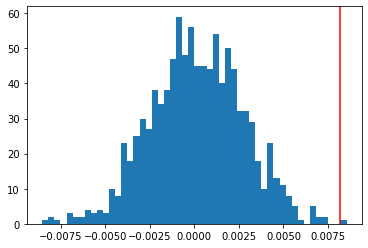

0.001

In [126]:
### p-value(0.001)<alpha(0.5) 이므로 기각, A 그룹이 B 그룹보다 Retention_1 이 높다. 

permutation_test('retention_7')